# Train Fast R-CNN
This code is inspired by this [link](https://towardsdatascience.com/understanding-and-implementing-faster-r-cnn-a-step-by-step-guide-11acfff216b0). <br>
The following image describes the topology of the Fast R-CNN

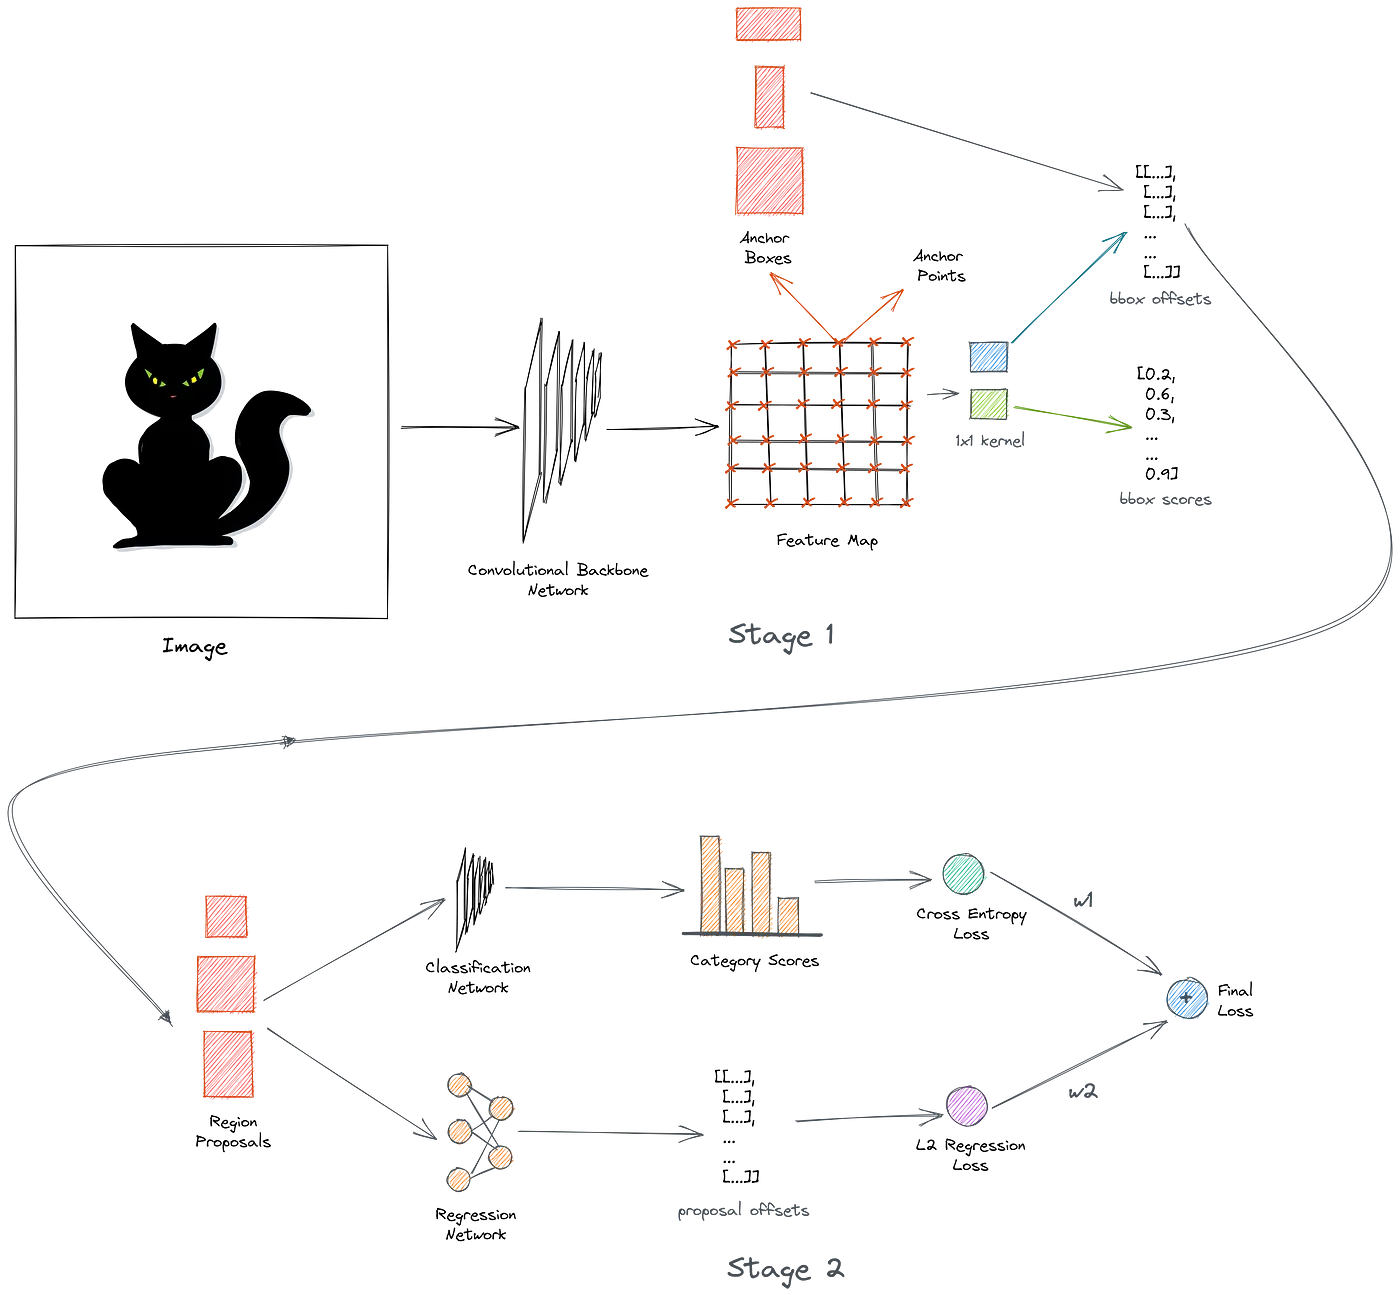

In [1]:
!pip install pycocotools

In [2]:
import os
import numpy as np
import json
from PIL import Image

import torch
import torchvision

from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.optim import Adam

In [3]:
class COCODataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None, image_prefix="train_", file_type=".png"):
        self.root_dir = root_dir
        self.transform = transform
        self.image_prefix = image_prefix
        self.file_type = file_type

        # Create dict with image ID as key and bboxes and categories as arrays
        self.image_dict = {}
        # Load the annotations from the JSON file
        with open(annotation_file) as f:
            data = json.load(f)
        # Filter annotations by category_id == 3 (Dental issues)
        filtered_annotations = [annotation for annotation in data['annotations'] if annotation['category_id'] == 3]
        for annotation in filtered_annotations:
            image_id = annotation['image_id']
            bbox = list(map(int, annotation['bbox']))
            # Convert bbox to [x_min, y_min, x_max, y_max]
            bbox = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
            category_id = annotation['category_id']

            # Check if the image file exists
            img_path = os.path.join(self.root_dir, self.image_prefix + str(image_id) + self.file_type)
            if not os.path.exists(img_path):
                continue

            if image_id not in self.image_dict:
                self.image_dict[image_id] = {'boxes': [], 'labels': []}
        
            # Append the bbox and category_id to the respective lists
            self.image_dict[image_id]['boxes'].append(bbox)
            self.image_dict[image_id]['labels'].append(category_id)

    def __len__(self):
        return len(self.image_dict)

    def __getitem__(self, idx):
        # Get the image_id from the keys of the image_dict
        image_id = list(self.image_dict.keys())[idx]
        # Construct the image path using the image_id
        img_path = os.path.join(self.root_dir, self.image_prefix + str(image_id) + self.file_type)
        # Open the image
        image = Image.open(img_path).convert("L")
        # Apply the transform if it's not None
        if self.transform:
            image = self.transform(image)
        # Get the annotations for this image
        annotations = self.image_dict[image_id]
        
        # Convert the annotations to the expected format
        targets = {}
        targets['boxes'] = torch.as_tensor(annotations['boxes'], dtype=torch.float32)
        targets['labels'] = torch.as_tensor(annotations['labels'], dtype=torch.int64)
        return image, targets

In [4]:
BATCH_SIZE = 16
NUM_WORKERS = 1

data_dir = './dentex_dataset/coco/disease_all/train2017'
annotations = './dentex_dataset/coco/disease_all/annotations/instances_train2017.json'

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to 256x256
    transforms.ToTensor(),  # Convert PIL Image to Tensor
])

# Create the dataset
dataset = COCODataset(root_dir=data_dir, annotation_file=annotations, transform=transform)

# Define the size of the validation set
val_size = int(0.2 * len(dataset))  # 20% for validation
train_size = len(dataset) - val_size

# Split the dataset into training and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

def collate_fn(batch):
    max_num_boxes = max(len(item[1]) for item in batch)
    
    images = []
    targets = []
    
    for image, target in batch:
        images.append(image)
        
        # Pad target if it has fewer boxes
        if len(target) < max_num_boxes:
            target = np.pad(target, ((0, max_num_boxes - len(target)), (0, 0)), mode='constant')
        
        targets.append(target)
    
    # Convert each dictionary in targets to tensor
    targets = [{k: torch.as_tensor(v) for k, v in t.items()} for t in targets]
    
    return images, targets

# Define your data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, collate_fn=collate_fn)

In [5]:
# Load a pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier with a new one, that has num_classes which is user-defined
num_classes = 4  # 1 class (person) + background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
# Define your optimizer
lr = 0.0001
optimizer = Adam(model.parameters(), lr=lr)

In [7]:
def train_model(model, train_dataloader, validation_dataloader, optimizer, num_epochs=30):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, annotations in train_dataloader:
            images = [image.to(device) for image in images]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
            loss_dict = model(images, annotations)
            losses = sum(loss for loss in loss_dict.values())
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            train_loss += losses.item()
        avg_train_loss = train_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        model.eval()
        with torch.no_grad():
            val_loss = 0
            for images, annotations in validation_dataloader:
                images = [image.to(device) for image in images]
                annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
                loss_dict, _ = eval_forward(model, images, annotations)
                val_losses += sum(loss.sum().item() if loss.dim() else loss.item() for loss in loss_dict.values()) if loss_dict else 0
            avg_val_loss = val_loss / len(validation_dataloader)
            val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

    return model, train_losses, val_losses

In [ ]:
test = train_model(
    model=model,
    train_dataloader=train_loader,
    optimizer=optimizer,
    num_epochs=10
)

In [ ]:
raise Exception()

In [ ]:
def train_and_save(model, train_dataloader, val_dataloader, optimizer, num_epochs=30, patience=2, save_path='FastRCNN.pt'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    metrics = {
        'train': {'total': [], 'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': []},
        'val': {'total': [], 'loss_classifier': [], 'loss_box_reg': [], 'loss_objectness': [], 'loss_rpn_box_reg': []}
    }
    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        epoch_losses = {'loss_classifier': 0, 'loss_box_reg': 0, 'loss_objectness': 0, 'loss_rpn_box_reg': 0}
        for images, annotations in train_dataloader:
            images = [image.to(device) for image in images]
            annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

            loss_dict = model(images, annotations)
            losses = sum(loss for loss in loss_dict.values())

            for key in epoch_losses.keys():
                epoch_losses[key] += loss_dict[key].item()

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        epoch_loss /= len(train_dataloader)
        metrics['train']['total'].append(epoch_loss)

        for key in epoch_losses.keys():
            epoch_losses[key] /= len(train_dataloader)
            metrics['train'][key].append(epoch_losses[key])

        val_loss = 0
        val_losses_dict = {'loss_classifier': 0, 'loss_box_reg': 0, 'loss_objectness': 0, 'loss_rpn_box_reg': 0}
        model.eval()
        with torch.no_grad():
            for images, annotations in val_dataloader:
                images = [image.to(device) for image in images]
                annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

                loss_dict = model(images, annotations)
                losses = sum(loss for loss in loss_dict.values())

                for key in val_losses_dict.keys():
                    val_losses_dict[key] += loss_dict[key].item()

                val_loss += losses.item()

        val_loss /= len(val_dataloader)
        metrics['val']['total'].append(val_loss)

        for key in val_losses_dict.keys():
            val_losses_dict[key] /= len(val_dataloader)
            metrics['val'][key].append(val_losses_dict[key])

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

        if epoch > 0 and metrics['val']['total'][-2] < val_loss:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                return metrics
        else:
            epochs_no_improve = 0
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), f'FastRCNN_{save_path}_best.pt')

    return metrics

In [ ]:
# Execute the training function
train_losses, val_losses = train_and_save(
    model=model,
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    optimizer=optimizer,
    num_epochs=10,
    patience=2
)

In [ ]:
import matplotlib.pyplot as plt

# Plot the training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from pycocotools.cocoeval import COCOeval

def evaluate(model, data_loader, device):
    model.eval()
    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            torch.cuda.synchronize()
            model_time = time.time()
            outputs = model(images)

            outputs = [{k: v.to(device) for k, v in t.items()} for t in outputs]
            res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
            evaluator_time = time.time()
            coco_evaluator.update(res)

    coco_evaluator.synchronize_between_processes()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()